<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20230521.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis
* Iterators

In [4]:
import pandas as pd
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time, timezone, timedelta 
import os
import re
from functools import reduce
from collections import defaultdict
from scipy import stats
from scipy.stats import norm

# Customer Analysis

In [5]:
os.listdir()

['.config',
 'WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv',
 'scanner_data.csv',
 'online_retail.xlsx',
 'lead_conversion.csv',
 'match_result_test.csv',
 '1_order_payments_dataset.csv',
 '1_orders_dataset.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 'app_wau.csv',
 'mock_sales_data.csv',
 'sample-sales-data.csv',
 'mall_customers.csv',
 'sales_vs_discount.csv',
 'ecommerce-data.csv',
 'sales.csv',
 'bz_data_analyis.csv',
 'sales_data_with_stores.csv',
 'groceries.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'ab_experiment.csv',
 'online_retail_II.xlsx',
 'WA_Fn-UseC_-Telco-Customer-Churn.csv',
 'cookie_cats.csv',
 'test.csv',
 '1_customers_dataset.csv',
 'sample_data']

In [13]:
df = pd.read_csv('scanner_data.csv')
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df.columns = [a.lower() for a in df.columns]
df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
df['week'] = df['date'] - df['date'].dt.weekday.astype('timedelta64[D]')
df['weekday'] = df['date'].dt.weekday
df['rev'] = df.quantity * df.sales_amount
df.head()

,date,customer_id,transaction_id,sku_category,sku,quantity,sales_amount,week,weekday,rev
0,2016-01-02,2547,1,X52,0EM7L,1.0,3.13,2015-12-28,5,3.13
1,2016-01-02,822,2,2ML,68BRQ,1.0,5.46,2015-12-28,5,5.46
2,2016-01-02,3686,3,0H2,CZUZX,1.0,6.35,2015-12-28,5,6.35
3,2016-01-02,3719,4,0H2,549KK,1.0,5.59,2015-12-28,5,5.59
4,2016-01-02,9200,5,0H2,K8EHH,1.0,6.88,2015-12-28,5,6.88


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            131706 non-null  datetime64[ns]
 1   customer_id     131706 non-null  int64         
 2   transaction_id  131706 non-null  int64         
 3   sku_category    131706 non-null  object        
 4   sku             131706 non-null  object        
 5   quantity        131706 non-null  float64       
 6   sales_amount    131706 non-null  float64       
 7   week            131706 non-null  datetime64[ns]
 8   weekday         131706 non-null  int64         
 9   rev             131706 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(3), object(2)
memory usage: 10.0+ MB


In [17]:
df.isnull().sum()

date              0
customer_id       0
transaction_id    0
sku_category      0
sku               0
quantity          0
sales_amount      0
week              0
weekday           0
rev               0
dtype: int64

In [20]:
df['date'].agg(['min','max'])

min   2016-01-02
max   2016-12-31
Name: date, dtype: datetime64[ns]

In [19]:
list_weekday = dict(zip(range(7), ['mon','tue','wed','thu','fri','sat','sun']))
df['weekday'] = df['weekday'].apply(lambda x : list_weekday.get(x,x))
df['weekday'] = pd.Categorical(df['weekday'], categories = list_weekday.values())
df.head()

,date,customer_id,transaction_id,sku_category,sku,quantity,sales_amount,week,weekday,rev
0,2016-01-02,2547,1,X52,0EM7L,1.0,3.13,2015-12-28,sat,3.13
1,2016-01-02,822,2,2ML,68BRQ,1.0,5.46,2015-12-28,sat,5.46
2,2016-01-02,3686,3,0H2,CZUZX,1.0,6.35,2015-12-28,sat,6.35
3,2016-01-02,3719,4,0H2,549KK,1.0,5.59,2015-12-28,sat,5.59
4,2016-01-02,9200,5,0H2,K8EHH,1.0,6.88,2015-12-28,sat,6.88


In [21]:
df['month'] = df['date'].dt.month
df.head()

,date,customer_id,transaction_id,sku_category,sku,quantity,sales_amount,week,weekday,rev,month
0,2016-01-02,2547,1,X52,0EM7L,1.0,3.13,2015-12-28,sat,3.13,1
1,2016-01-02,822,2,2ML,68BRQ,1.0,5.46,2015-12-28,sat,5.46,1
2,2016-01-02,3686,3,0H2,CZUZX,1.0,6.35,2015-12-28,sat,6.35,1
3,2016-01-02,3719,4,0H2,549KK,1.0,5.59,2015-12-28,sat,5.59,1
4,2016-01-02,9200,5,0H2,K8EHH,1.0,6.88,2015-12-28,sat,6.88,1


In [24]:
cnt_q = df.groupby(['month','weekday'])['sales_amount'].quantile([.25, .5, .75, .95]).reset_index().rename(columns = {'level_2':'q'})
cnt_q.head()

,month,weekday,q,sales_amount
0,1,mon,0.25,4.23
1,1,mon,0.50,6.75
2,1,mon,0.75,11.37
3,1,mon,0.95,32.97
4,1,tue,0.25,4.20


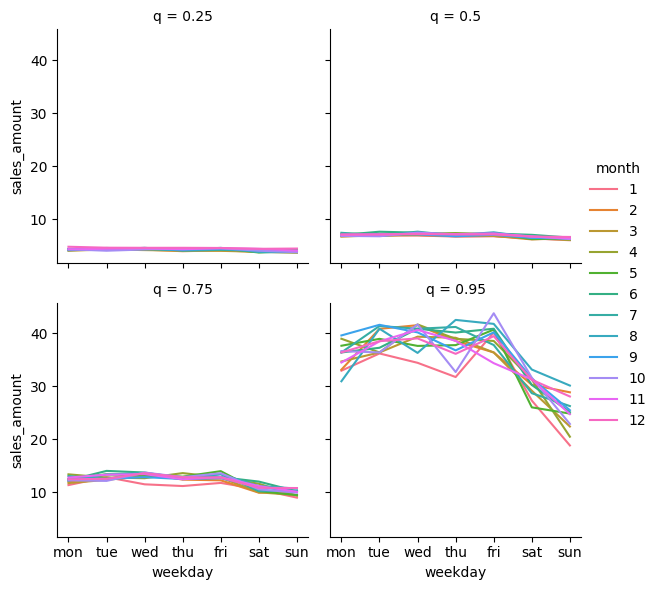

In [29]:
g = sns.FacetGrid(cnt_q, col = 'q', hue = 'month', col_wrap = 2)
g.map(sns.lineplot, 'weekday', 'sales_amount')
g.add_legend()
plt.show()

In [36]:
cnt_rev = df.groupby(['month','date','weekday'])['rev'].sum().reset_index(name = 'rev')
cnt_rev = cnt_rev[cnt_rev['rev'] != 0]

In [37]:
cnt_q2 = cnt_rev.groupby(['month','weekday'])['rev'].quantile([.25, .5, .75, .95]).reset_index().rename(columns = {'level_2':'q'})
cnt_q2.head()

,month,weekday,q,rev
0,1,mon,0.25,5832.74500
1,1,mon,0.50,7228.07000
2,1,mon,0.75,8711.87080
3,1,mon,0.95,8975.20072
4,1,tue,0.25,9159.55460


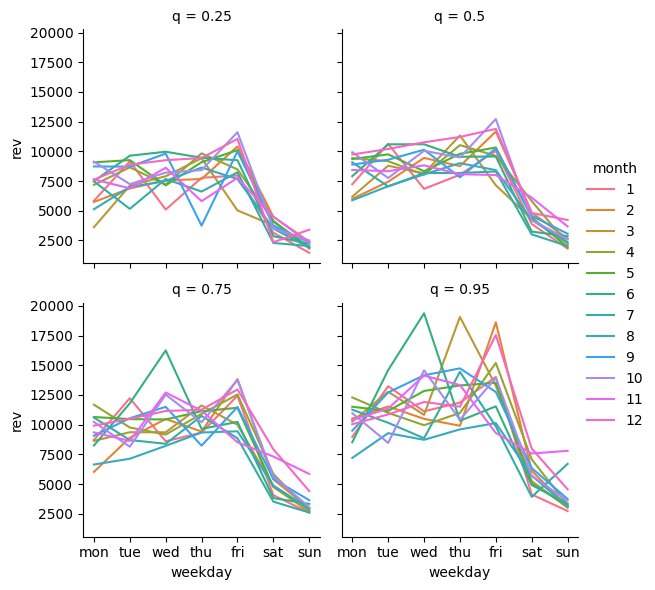

In [38]:
g = sns.FacetGrid(cnt_q2, col = 'q', hue = 'month', col_wrap = 2)
g.map(sns.lineplot, 'weekday', 'rev')
g.add_legend()
plt.show()

In [39]:
cnt_day = df.groupby(['date','weekday'])['customer_id'].count().reset_index(name = 'cnt')
cnt_day.head()

,date,weekday,cnt
0,2016-01-02,mon,0
1,2016-01-02,tue,0
2,2016-01-02,wed,0
3,2016-01-02,thu,0
4,2016-01-02,fri,0


<Axes: xlabel='date', ylabel='cnt'>

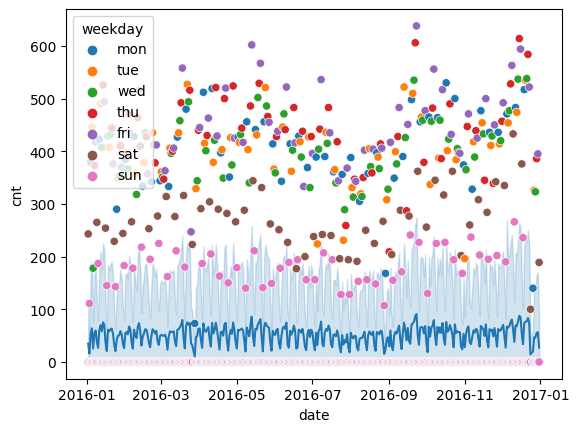

In [40]:
sns.lineplot(data = cnt_day, x = 'date', y = 'cnt')
sns.scatterplot(data = cnt_day, x = 'date', y = 'cnt', hue = 'weekday')
plt.show()

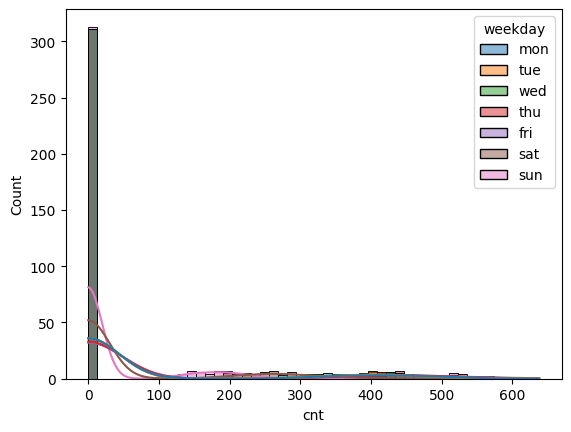

In [45]:
sns.histplot(data = cnt_day, x = 'cnt', hue = 'weekday', kde = True, bins = 50)
plt.show()

In [51]:
cnt_day2 = df.groupby(['month','date','weekday'])['customer_id'].count().reset_index(name = 'cnt')
cnt_day2['flag'] = ['o' if a != 0 else 'x' for a in cnt_day2['cnt']]
cnt_day2 = cnt_day2.groupby(['month','weekday','flag'])['date'].count().reset_index(name = 'cnt')
cnt_day2.head()

,month,weekday,flag,cnt
0,1,mon,o,4
1,1,mon,x,359
2,1,tue,o,4
3,1,tue,x,359
4,1,wed,o,4


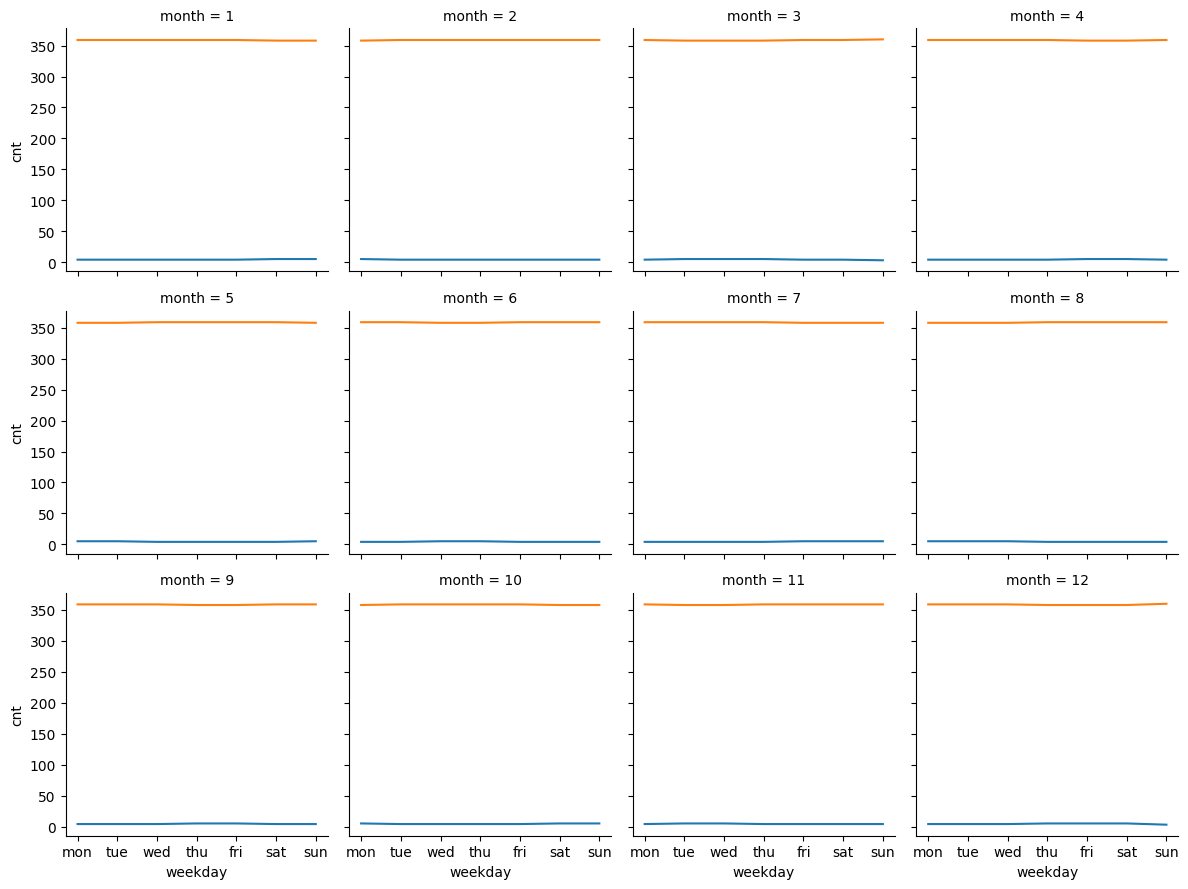

In [53]:
g = sns.FacetGrid(cnt_day2, col = 'month', hue = 'flag', col_wrap = 4)
g.map(sns.lineplot, 'weekday', 'cnt')
plt.show()

# Iterators

In [60]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [64]:
{k : eval(f'reduce(lambda acc, cur : acc + [cur["{k}"]], users, [])') for k in users[0].keys()}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}

In [65]:
{k : [user[k] for user in users] for k in users[0].keys()}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}